In [98]:
import pandas as pd
import numpy as np
import copy

from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os, sys, shutil, copy, time, random
from functools import partial

from sustain_dataset import *
from models import *
from utils import *

In [137]:
class Args:
    def __init__(self):
        self.dataset = "gdp"
        self.gpu = 0
        self.train_bias_f = False
        self.train_bias_y = False
        self.train_cons = False
        self.train_calib = False
        self.num_bins = 0
        self.run_label = 0
        self.model = 'linear' #'small' #'bigg' #'linear'
        self.learning_rate = 1e-3
        self.batch_size = 1024
        self.knn = 100
        self.log_root = './runs/unbiased'

In [138]:
def tax_utility(difference, beta=1.):
    # difference: y_0 - pred
    return beta * difference


def compute_utility(model, test_dataset, a=torch.relu, r=torch.log, y_0=0.3):
    inputs, labels = test_dataset[:]
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs).reshape(-1)
    labels = labels.reshape(-1)
    finacial_aid = a(y_0 - pred)
    after_finacial_aid = labels + finacial_aid
    # utility = r(2.+after_finacial_aid) # worked well
    utility = r(3.+after_finacial_aid)
    utility = utility.mean(dim=0)
    return utility

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

def plot_errbar(ax, x, y, c=None, label=None):
    mean = np.mean(y, axis=1)
    std = np.std(y, axis=1) / np.sqrt(y.shape[1])
    ax.plot(x, mean, label=label, c=c, linewidth=2.)
    ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.01)

loss 4.314465045928955
loss 0.39921319484710693
loss 10.292308807373047
loss 0.5005449056625366
loss 10.143898963928223
loss 0.38098499178886414
loss 2.264854669570923
loss 0.408873975276947
loss 0.46340930461883545
loss 0.4045180678367615
loss 0.7257913947105408
loss 0.4116441607475281
loss 2.636143684387207
loss 0.6419370174407959
loss 2.6625797748565674
loss 0.36961960792541504
loss 6.595396518707275
loss 0.6157613396644592
loss 2.99277925491333
loss 0.3914424479007721
0
tensor(0.4525, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.3092, device='cuda:0')


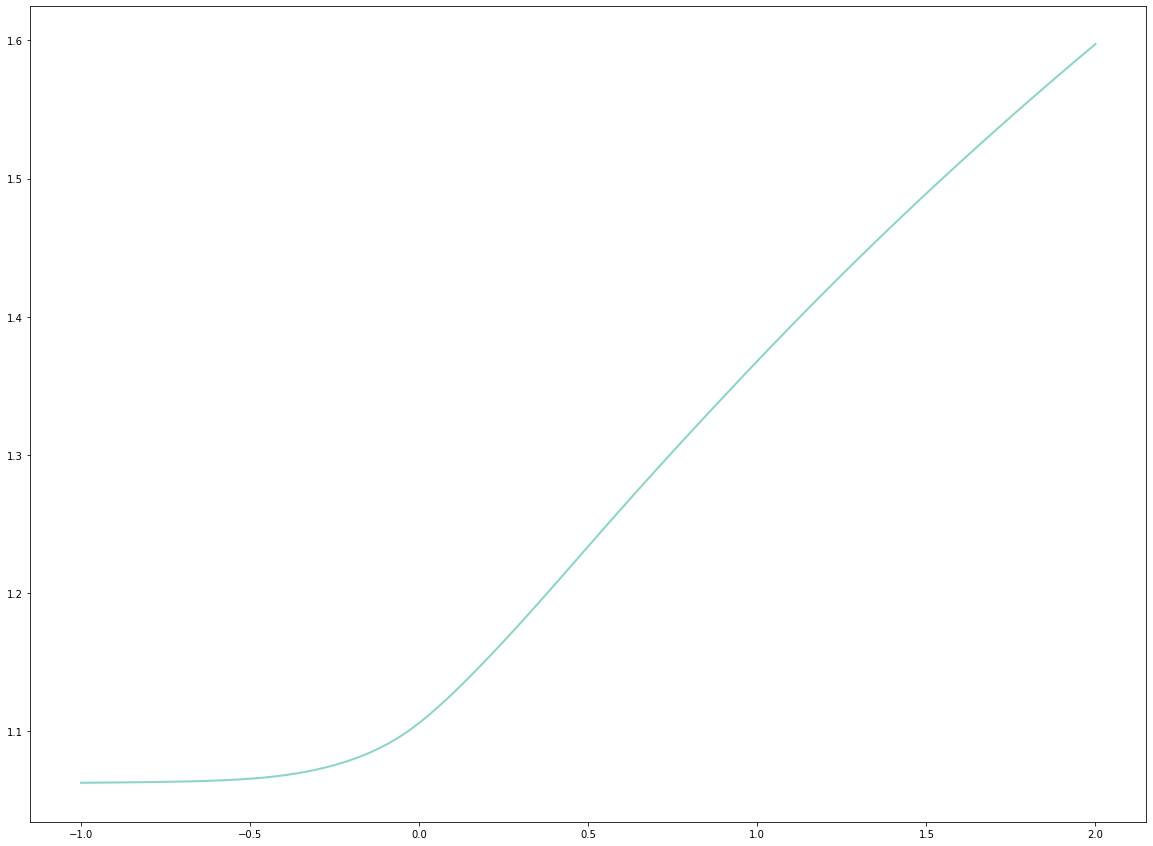

In [139]:
args = Args()
    
device = torch.device('cuda:%d' % args.gpu)
args.device = device
start_time = time.time()
run_labels = range(0, 10, 1)
utility_points = 100
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
colors = plt.cm.get_cmap('Set3').colors
# colors = ['r', 'g', 'c', 'm', 'k', 'orange', 'r', 'black']

loss_ = 0.
loss_rebias = 0.
axis= 'label' #'prediction'

for i, train_bias_y in enumerate([False]):
    for j, train_bias_f in enumerate([False]):
        for k, train_cons in enumerate([False]):
            for t, train_calib in enumerate([False]):

                # test_utility = np.zeros((utility_points + 18, len(run_labels)))
                test_utility = np.zeros((utility_points, len(run_labels)))

                labels_bias = None
                for run_label in run_labels:
                    args.name = '%s_knn/model=%s-%r-%r-%r-%r-bs=%d-run=%d' % \
                    (args.dataset, args.model, args.train_bias_y, args.train_bias_f, args.train_cons,
                     args.train_calib, args.batch_size, run_label)
#                     args.name = '%s_knn/model=%s-%r-%r-%r-%r-False-False-True-bs=%d-bin=%d-%d-run=%d' % \
#                                 (args.dataset, args.model, train_bias_y, train_bias_f, train_cons,
#                                  train_calib, args.batch_size, args.num_bins, args.knn, run_label)

                    args.log_dir = os.path.join(args.log_root, args.name)
                    if not os.path.isdir(args.log_dir):
                        print("dir not exist {}".format(args.name))
                        continue
#                     print(args.name)
                    ckpt = torch.load(os.path.join(args.log_dir, "ckpt.pth"))
                    train_dataset = ckpt[1]
                    test_dataset = ckpt[2]

                    # Define model and optimizer
                    model = model_list[args.model](train_dataset.x_dim).to(device)
                    model.load_state_dict(ckpt[0])

#                     flow = deeper_flow(layer_num=5, feature_size=20).to(device)  # one joint flow
#                     flow.load_state_dict(ckpt[4])

                    # Performance evaluation
                    with torch.no_grad():
                        u_array_bias = []
                        labels_bias = []

                        for y0 in np.linspace(-1.0, 2, utility_points):
                            u = compute_utility(model, test_dataset, y_0=y0).data.item()
                            # u = compute_utility(model, test_dataset, y_0=y0, r=(lambda x: torch.pow(x, 1./3.))).data.item()
                            # u = compute_utility(model, test_dataset, a=tax_utility, y_0=y0)  # .data.item()
                            #     print(u)
                            u_array_bias.append(u)
                            labels_bias.append(y0)

                    # plt.plot(labels_bias, u_array_bias, label="%r-%r-%r-%r"%(train_bias_y, train_bias_f, train_cons,
                    #          train_calib))
                    test_utility[:utility_points, run_label] = np.array(u_array_bias) #smooth(np.array(u_array_bias), 18)
                    model.recalibrator = RecalibratorBias(model, train_dataset[:], args, axis=axis)
                    model.eval()
                    loss, err_bias = make_plot(model, test_dataset[:], args, do_plot=False, axis=axis)
                    loss_rebias += loss
                    model.train()
                    loss, err_bias = make_plot(model, test_dataset[:], args, do_plot=False, axis=axis)
                    loss_ += loss
                if isinstance(labels_bias, type(None)):
                    continue
                print(int(k * 8 + i * 4 + j * 2 + t))
                plot_errbar(ax1, labels_bias, test_utility[:utility_points],
                            label='bias_y=%r-bias_f=%r-cons=%r-calib=%r' % (train_bias_y, train_bias_f, train_cons, train_calib),
                            c=colors[int(j * 8 + i * 4 + k * 2 + t)%12])

print(loss_/10.)
print(loss_rebias/10.)

#     # ax1.set_ylim([0.6, 1.5])
#     # ax1.set_ylim([1., 1.5])
#     fontsize = 36
#     if args.dataset == "gdp":
#         ax1.set_title("China GDP per capita prediction", fontsize=fontsize)
#     else:
#         ax1.set_title("Uganda poverty prediction", fontsize=fontsize)

#     ax1.legend(fontsize=fontsize)
#     ax1.set_xlabel(r"$y_0$", fontsize=fontsize)
#     ax1.set_ylabel(r"$u(\epsilon)$", fontsize=fontsize)

#     plt.tight_layout()
# #     plt.savefig('plots/result_{}_knn.png'.format(args.dataset))

In [112]:
class Recalibrator:
    def __init__(self, model, data, args):
        self.args = args
        self.model = model #regression model
        
        self.flow = NafFlow().to(args.device)
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        
        inputs, labels = data[0].to(args.device), data[1].to(args.device)
        with torch.no_grad():
            outputs = model(inputs)
        
        labels = torch.sort(labels.flatten())[0] #.cpu().numpy()
        outputs = torch.sort(outputs.flatten())[0] #.cpu().numpy()
#         self.iso = IsotonicRegression(out_of_bounds='clip', increasing=True)
#         self.iso = self.iso.fit(outputs, labels)

        for iteration in range(5000):
#             import pdb
#             pdb.set_trace()
            flow_optim.zero_grad()
            adjusted_outputs, _ = self.flow(outputs.view(-1, 1))
            loss_bias = (labels - adjusted_outputs.view(-1)).pow(2).mean()
            loss_bias.backward()
            flow_optim.step()

    def adjust(self, original_y):
#         original_shape = original_y.shape
        output = self.flow(original_y.reshape(-1,1).to(device))[0]
        return output.reshape(original_y.shape) 
    

In [113]:
# model.recalibrator = RecalibratorBias_flow(model, flow, args, axis='label')
model.recalibrator = RecalibratorBias(model, train_dataset[:], args, axis='prediction')
# model.recalibrator = Recalibrator_flow(model, flow, args)
# model.train()
# model.recalibrator = Recalibrator(model, train_dataset[:], args)

In [114]:
# model.eval()
# err_total_bias, errs_bias = eval_bias(model, test_dataset[:], args, axis='label')
# model.recalibrator.flow(test_dataset[:][1].reshape(-1,1).to(device))[0].shape

In [115]:
def eval_calibration(model, data, args):
    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device)
    
    outputs = model(inputs)
    
    labels, _ = torch.sort(labels.flatten())
    outputs, _ = torch.sort(outputs.flatten())
    
    loss_calib = (labels - outputs).pow(2).mean()
    return loss_calib, None


def make_plot(model, data, args, do_plot=True, axis='label'):
#     err_total_bias, errs_bias, smoothed_labels, smoothed_outputs = eval_bias_knn_plot(model, data, args)
#     err_total_bias, errs_bias, smoothed_labels, smoothed_outputs = err_total_bias.cpu(), errs_bias.cpu(), smoothed_labels.cpu(), smoothed_outputs.cpu()
#     args.num_bins = 20
#     err_total_bias, errs_bias = eval_bias(model, data, args, axis='label')
#     smoothed_labels, smoothed_outputs = smoothed_labels.cpu(), smoothed_outputs.cpu()
    if axis == "calib":
        loss, err_bias = eval_calibration(model, data, args)
    else:
        loss, err_bias = eval_bias_knn(model, data, args, axis=axis)
    
    if do_plot:
        fig = plt.figure(figsize=(6, 6))
        plt.bar(np.linspace(0, 1, args.num_bins+1)[:-1], err_bias, align='edge', width=0.05)
        plt.xlabel("smoothed labels", fontsize=20)
        plt.ylabel("smoothed outputs", fontsize=20)
        
        plt.xlim([-1.5, 2.6])
        plt.ylim([-1.5, 2.6])
    print("loss {}".format(loss.data.item()))
    return loss, err_bias

loss 0.015301072038710117
loss 0.017115384340286255


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

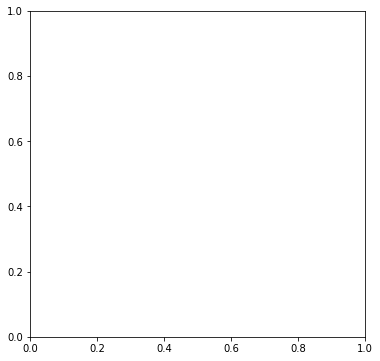

In [116]:
# calibrated_model = copy.deepcopy(model)
with torch.no_grad():
    model.eval()
#     calibrated_err_total_bias, calibrated_errs_bias = make_plot(model, test_dataset[:], args, do_plot=False, axis='calib')
#     calibrated_err_total_bias, calibrated_errs_bias = make_plot(model, test_dataset[:], args, do_plot=False, axis='label')
    calibrated_err_total_bias, calibrated_errs_bias = make_plot(model, test_dataset[:], args, do_plot=False, axis='prediction')
    model.train()
    err_total_bias, errs_bias = make_plot(model, test_dataset[:], args, do_plot=False, axis='prediction')
    
    fig = plt.figure(figsize=(6, 6))
    plt.bar(np.linspace(0, 1, args.num_bins+1)[:-1], calibrated_errs_bias, align='edge', width=0.05, alpha=0.5, label="bias_label")
    plt.bar(np.linspace(0, 1, args.num_bins+1)[:-1], errs_bias, align='edge', width=0.05, alpha=0.5, label="original")
    
#     plt.scatter(calibrated_smoothed_labels, calibrated_smoothed_outputs, s=1, c="b", label="bias_label")
#     plt.scatter(smoothed_labels, smoothed_outputs, s=1, c="orange", label="original")
#     plt.xlabel("smoothed labels", fontsize=20)
#     plt.ylabel("smoothed outputs", fontsize=20)
    plt.ylim([-1, 2])
#     plt.ylim([-0.7, 0.2])
#     plt.plot(np.linspace(-2.6, 2.6, 60), np.linspace(-2.6, 2.6, 60))
    plt.legend(fontsize=20)

In [40]:
test_dataset[:][1].shape, test_dataset[:][1].mean()

(torch.Size([1836, 1]), tensor(0.0160))

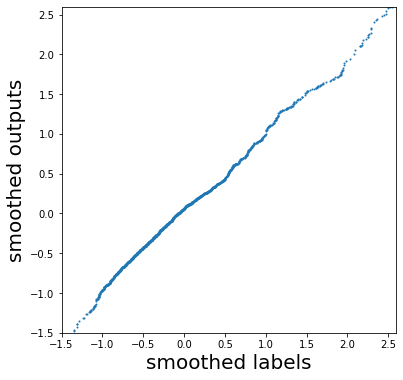

In [92]:
with torch.no_grad():
    make_plot(model, test_dataset[:], args, do_plot=True)

In [99]:
model.recalibrator
calibrated_model.recalibrator

In [43]:
class GDP_Dataset(Dataset):
    def __init__(self, train=True, normalize=False, random_permute=True, permutation=None, doc="sustain_dataset/gdp_data/CHN_no2_train.pkl", partition=0.3):
        super(GDP_Dataset, self).__init__()
        pd_data = pd.read_pickle(doc)

        data = pd_data[[
            'avg_lights_x_pct_max',
            'avg_lights_x_pct_mean', 'avg_lights_x_pct_stdDev',
            'avg_lights_x_pct_sum', 'avg_vis_max', 'avg_vis_mean', 'avg_vis_stdDev',
            'avg_vis_sum', 'cf_cvg_max', 'cf_cvg_mean', 'cf_cvg_stdDev',
            'cf_cvg_sum', 'stable_lights_max', 'stable_lights_mean',
            'stable_lights_stdDev', 'stable_lights_sum', 'cvg_diff',
            'light_sum_diff',
            'GDP_cap']]

        data = data.replace('?', np.nan)
        data = data.replace([-np.inf, np.inf], np.nan)
        data = data.dropna(axis=1)

        data_torch = torch.from_numpy(data.to_numpy()).type(torch.float32)
        if random_permute:
            data_torch = data_torch[torch.randperm(data_torch.shape[0])]
        else:
            data_torch = data_torch[permutation]

        data_x = data_torch[:, :-1]
        data_y = data_torch[:, -1]

        # pdb.set_trace()
        # Normalize data_y
        if normalize:
            data_y = (torch.argsort(torch.argsort(data_y)).type(torch.float) / data_y.shape[0]).view(-1, 1)
        else:
            data_y = data_y.view(-1, 1)

        partition = int((1 - partition) * data_x.shape[0])
        self.mean = torch.mean(data_x[:partition], dim=0, keepdim=True)
        self.std = torch.std(data_x[:partition], dim=0, keepdim=True)

        self.mean_y = torch.mean(data_y[:partition], dim=0, keepdim=True)
        self.std_y = torch.std(data_y[:partition], dim=0, keepdim=True)
        self.total_data = data_x.shape[0]

        if train:
            self.data_x = data_x[:partition]
            self.data_y = data_y[:partition]
        else:
            self.data_x = data_x[partition:]
            self.data_y = data_y[partition:]

        # self.data_x = data_x
        # self.data_y = data_y

        if not normalize:
            print("mean_y {}:".format(self.mean_y))
            print("std_y {}:".format(self.std_y))
            
            self.data_y = (self.data_y - self.mean_y) / self.std_y

        self.data_x = (self.data_x - self.mean) / self.std
        self.x_dim = data_x.shape[-1]

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

In [47]:
# Define dataset and dataset loader
Dataset = GDP_Dataset# dataset_list[args.dataset]
total_data = Dataset().total_data
permutation = torch.randperm(total_data)

train_dataset_ = Dataset(train=True, random_permute=False, permutation=permutation)
test_dataset_ = Dataset(train=False, random_permute=False, permutation=permutation) # could have overlapping
# train_dataset_[:][1].mean()

mean_y tensor([[1.3325]]):
std_y tensor([[0.6245]]):
mean_y tensor([[1.3447]]):
std_y tensor([[0.6481]]):
mean_y tensor([[1.3447]]):
std_y tensor([[0.6481]]):
